# **Analysis of data and visualization of rental properties in New York area.**

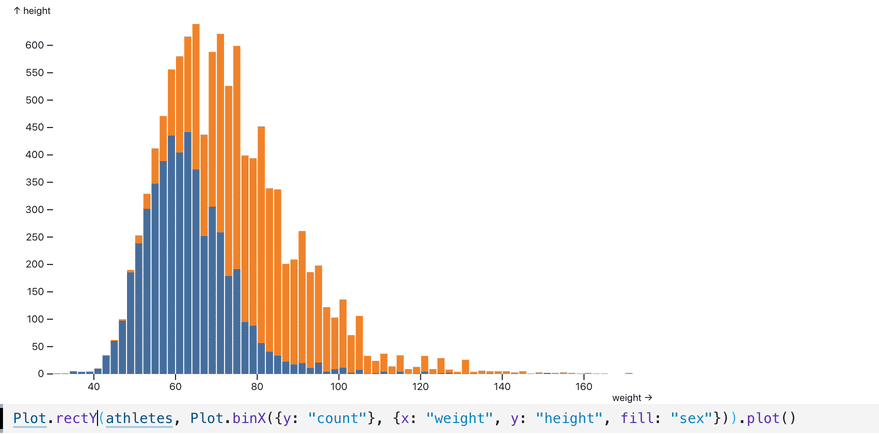

##**Calling Libraries**

In [1]:

# 1.0 Call libraries
%reset -f
# 1.1 For data manipulations
import numpy as np
import pandas as pd
from numpy.random import default_rng

# 1.2 For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl     # For creating colormaps

# 1.3 For data processing
from sklearn.preprocessing import StandardScaler

# 1.4 OS related
import os

# 1.5 for working in ipython
#%matplotlib qt5
#%matplotlib inline

from scipy.stats import scoreatpercentile, pearsonr

##**Read DataSet**

In [2]:
bnb = pd.read_csv("../input/airbnb/Airbnb_Open_Data.csv",
                  parse_dates = ['last review'] 
                );

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
bnb.dtypes

id                                         int64
NAME                                      object
host id                                    int64
host_identity_verified                    object
host name                                 object
neighbourhood group                       object
neighbourhood                             object
lat                                      float64
long                                     float64
country                                   object
country code                              object
instant_bookable                          object
cancellation_policy                       object
room type                                 object
Construction year                        float64
price                                     object
service fee                               object
minimum nights                           float64
number of reviews                        float64
last review                       datetime64[ns]
reviews per month   

##**Rename Columns to remove spaces**

In [4]:
bnb.rename(columns = {'host id':'HostId','host name':'HostName',
                     'neighbourhood group':'NeighbourhoodGroup',
                     'country code':'countryCode','room type':'roomType',
                     'Construction year':'constructionYear','service fee':'serviceFee',
                     'minimum nights':'minimumNights','number of reviews':'numberOfReviews',
                     'last review':'lastReview','reviews per month':'reviewsPerMonth',
                     'review rate number':'reviewRateNumber','calculated host listings count':'calculatedHostListingsCount',
                     'availability 365':'availability-365'}, inplace = True)

In [5]:
bnb.columns

Index(['id', 'NAME', 'HostId', 'host_identity_verified', 'HostName',
       'NeighbourhoodGroup', 'neighbourhood', 'lat', 'long', 'country',
       'countryCode', 'instant_bookable', 'cancellation_policy', 'roomType',
       'constructionYear', 'price', 'serviceFee', 'minimumNights',
       'numberOfReviews', 'lastReview', 'reviewsPerMonth', 'reviewRateNumber',
       'calculatedHostListingsCount', 'availability-365', 'house_rules',
       'license'],
      dtype='object')

##**Drop columns that are not useful for analysis**

In [6]:
bnb.drop(['country','countryCode','id','NAME','HostName','house_rules'],axis=1,inplace=True)

In [7]:
bnb.columns

Index(['HostId', 'host_identity_verified', 'NeighbourhoodGroup',
       'neighbourhood', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'roomType', 'constructionYear', 'price',
       'serviceFee', 'minimumNights', 'numberOfReviews', 'lastReview',
       'reviewsPerMonth', 'reviewRateNumber', 'calculatedHostListingsCount',
       'availability-365', 'license'],
      dtype='object')

##**convert the contruction year type to int to get rid of the decimal**

In [8]:
bnb['constructionYear']=bnb['constructionYear'].astype('Int64')

##**Replace the '$' preffix from the data in 'price' amd 'serviceFee' columns**

In [9]:
bnb['price']=bnb['price'].str.lstrip('$')
bnb['serviceFee']=bnb['serviceFee'].str.lstrip('$')

##**Explore Data**

In [10]:
bnb.shape

(102599, 20)

In [11]:
bnb['roomType'].nunique() #count of unique room types

4

In [12]:
print(pd.unique(bnb['roomType']).reshape(-1, 1)) #identified the 4 different types of room types listed

[['Private room']
 ['Entire home/apt']
 ['Shared room']
 ['Hotel room']]


**observation : 'roomType' is a categorical feature.**

In [13]:
bnb['constructionYear'].min()

2003

In [14]:
bnb['constructionYear'].max() #listed properties were constructed between 2003 and 2022

2022

**All properties were costructed between 2003 to 2022**

In [15]:
len(bnb['HostId'].value_counts()[lambda x: x>1].index.tolist())

542

**observation : There are 542 hosts owning more than one property**

In [16]:
print(bnb['license'].unique().reshape(-1, 1))

[[nan]
 ['41662/AL']]


In [17]:
len(bnb[bnb['license']=='41662/AL'].axes[0])

2

observation : only two of the properties belonging to two different hosts are licensed.

In [18]:
print(bnb['host_identity_verified'].unique().reshape(-1, 1))

[['unconfirmed']
 ['verified']
 [nan]]


In [19]:
bnb[bnb['host_identity_verified']=='unconfirmed'].shape

(51200, 20)

In [20]:
print(bnb['instant_bookable'].unique().reshape(-1,1))

[[False]
 [True]
 [nan]]


There are 51110 verified properties and 51200 unconfirmed properties

In [21]:
bnb[bnb['instant_bookable']==True].shape

(51020, 20)

In [22]:
bnb[bnb['instant_bookable']==False].shape

(51474, 20)

**Observation : There are 51020 instant bookable properies and 51474 properties that cannot be instantly booked**

convert dtype 'object' to 'int' by using to_numeric function of pandas(https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int)

In [23]:
bnb['price']=pd.to_numeric(bnb['price'], errors='coerce').convert_dtypes()
#bnb['price']=bnb['price'].fillna(0)
print("min value")
print(bnb['price'].min(skipna=True))
print("max value")
print(bnb['price'].max(skipna=True))

min value
50
max value
999


In [24]:
bnb['serviceFee']=pd.to_numeric(bnb['serviceFee'], errors='coerce').convert_dtypes()
#bnb['price']=bnb['price'].fillna(0)
print("min serviceFee value")
print(bnb['serviceFee'].min(skipna=True))
print("max serviceFee value")
print(bnb['serviceFee'].max(skipna=True))

min serviceFee value
10
max serviceFee value
240


##**Feature Engineering**

In [25]:
bnb['serviceAsFracOfPrice']=bnb['serviceFee']/bnb['price']

In [26]:
bnb['totalBill']=bnb['serviceFee']+bnb['price']

In [27]:
print("minimum percentage of service fee charged as percentage of price")
print(bnb['serviceAsFracOfPrice'].min(skipna=True))
print("maximum percentage of service fee charged as percentage of price")
print(bnb['serviceAsFracOfPrice'].max(skipna=True))

minimum percentage of service fee charged as percentage of price
0.19230769230769232
maximum percentage of service fee charged as percentage of price
0.20754716981132076


**Observation:service fee charged is between 19.23% to 20.75% of the price of the property.**

In [28]:
bnb['price'].groupby(bnb['roomType']).min()

roomType
Entire home/apt    50
Hotel room         50
Private room       50
Shared room        50
Name: price, dtype: Int64

In [29]:
bnb['price'].groupby(bnb['roomType']).max()

roomType
Entire home/apt    999
Hotel room         994
Private room       999
Shared room        998
Name: price, dtype: Int64

**observation : minimum price of property across roomtypes is 50 dollars. maximum price of property across roomtypes is 999 dollars**

In [30]:
bnb['serviceFee']=pd.to_numeric(bnb['serviceFee'], errors='coerce').convert_dtypes()
#bnb['serviceFee']=bnb['serviceFee'].fillna(0)

In [31]:
bnb['price'].max(skipna=True)

999

In [32]:
bnb['price'].min(skipna=True)

50

In [33]:
bnb.replace(to_replace='brookln',value='Brooklyn',inplace=True) # replace the value brooklyn with Brooklyn 

In [34]:
bnb.replace(to_replace='manhatan',value='Manhattan',inplace=True)# replace the value manhatan with Manhattan 

In [35]:
bnb['NeighbourhoodGroup'].value_counts()

Manhattan        43793
Brooklyn         41843
Queens           13267
Bronx             2712
Staten Island      955
Name: NeighbourhoodGroup, dtype: int64

**observation:Manhattan neighbourhood group has the highest number of properies. neighbourhoodgroup is categorical data**

In [36]:
bnb['Budget'] = pd.cut(bnb['price'], bins = 4, labels = ["Semi Deluxe","Deluxe","3 star","5 star"])

In [37]:
bnb[['price','Budget']]

,price,Budget
0,966,5 star
1,142,Semi Deluxe
2,620,3 star
3,368,Deluxe
4,204,Semi Deluxe
...,...,...
102594,844,5 star
102595,837,5 star
102596,988,5 star
102597,546,3 star


In [38]:
bnb['cancellation_policy'].value_counts()

moderate    34343
strict      34106
flexible    34074
Name: cancellation_policy, dtype: int64

**observation : cancellation_policy is of 3 types and is a categorical feature.**

In [39]:
bnb.columns

Index(['HostId', 'host_identity_verified', 'NeighbourhoodGroup',
       'neighbourhood', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'roomType', 'constructionYear', 'price',
       'serviceFee', 'minimumNights', 'numberOfReviews', 'lastReview',
       'reviewsPerMonth', 'reviewRateNumber', 'calculatedHostListingsCount',
       'availability-365', 'license', 'serviceAsFracOfPrice', 'totalBill',
       'Budget'],
      dtype='object')

In [40]:
bnb['reviewRateNumber'].value_counts()

5.0    23369
4.0    23329
3.0    23265
2.0    23098
1.0     9212
Name: reviewRateNumber, dtype: int64

reviewRateNumber is of 5 types and is a categorical feature

In [41]:
bnb['minimumNightsCategory']=pd.cut(bnb['minimumNights'], bins = [1,5,10,30,825], labels = ["veryFew","Few","Moderate","High"])


In [42]:
bnb[['minimumNights','minimumNightsCategory']]

,minimumNights,minimumNightsCategory
0,10.0,Few
1,30.0,Moderate
2,3.0,veryFew
3,30.0,Moderate
4,10.0,Few
...,...,...
102594,1.0,NaN
102595,1.0,NaN
102596,3.0,veryFew
102597,2.0,veryFew


In [43]:
bnb['minimumNightsCategory'].value_counts()

veryFew     52393
Moderate    15753
Few          6912
High         1687
Name: minimumNightsCategory, dtype: int64

##**Plotting**

In [44]:
bnb.columns

Index(['HostId', 'host_identity_verified', 'NeighbourhoodGroup',
       'neighbourhood', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'roomType', 'constructionYear', 'price',
       'serviceFee', 'minimumNights', 'numberOfReviews', 'lastReview',
       'reviewsPerMonth', 'reviewRateNumber', 'calculatedHostListingsCount',
       'availability-365', 'license', 'serviceAsFracOfPrice', 'totalBill',
       'Budget', 'minimumNightsCategory'],
      dtype='object')

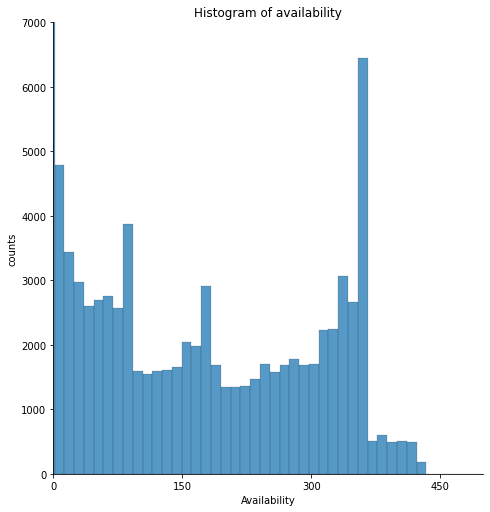

In [45]:
ax= sns.displot(bnb['availability-365'],kind='hist',height=7)
ax.set(                  #  sns.distplot does not have **kwargs
        xlabel= "Availability", ylabel = "counts",    
        title= "Histogram of availability", xticks = list(range(0,500,150)),
       xlim=(0,500), ylim=(0,7000)
        );

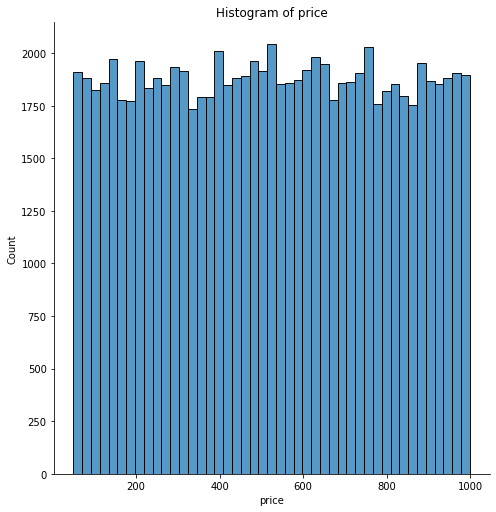

In [46]:
ax=sns.displot(bnb['price'],kind='hist',height=7);
ax.set(title= "Histogram of price");


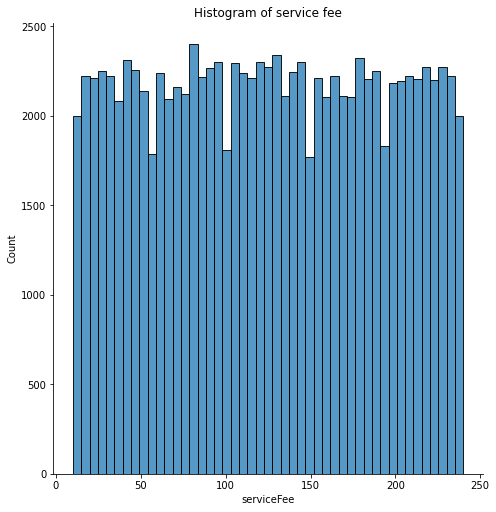

In [47]:
ax=sns.displot(bnb['serviceFee'],kind='hist',height=7);
ax.set(title= "Histogram of service fee");

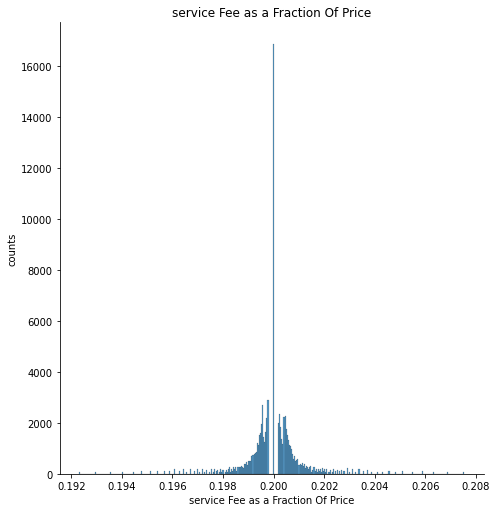

In [48]:
ax=sns.displot(bnb['serviceAsFracOfPrice'],kind='hist',height=7);
ax.set(                  #  sns.distplot does not have **kwargs
        xlabel= "service Fee as a Fraction Of Price", ylabel = "counts",    
        title= "service Fee as a Fraction Of Price"
        );

In [49]:
filtered_servToPrice = bnb[bnb['serviceAsFracOfPrice'].notnull()]

In [50]:
scoreatpercentile(filtered_servToPrice.serviceAsFracOfPrice,99)

0.20408163265306123

In [51]:
filtered_servToPrice[filtered_servToPrice['serviceAsFracOfPrice']==0.20408163265306123].size

2064

In [52]:
filtered_servToPrice[filtered_servToPrice['serviceAsFracOfPrice']<0.18].size

0

**observation : all the properties charger service fee between 18 to 20 percent of the price of the property.**

In [53]:
filtered_bnb = bnb[bnb['constructionYear'].notnull()]

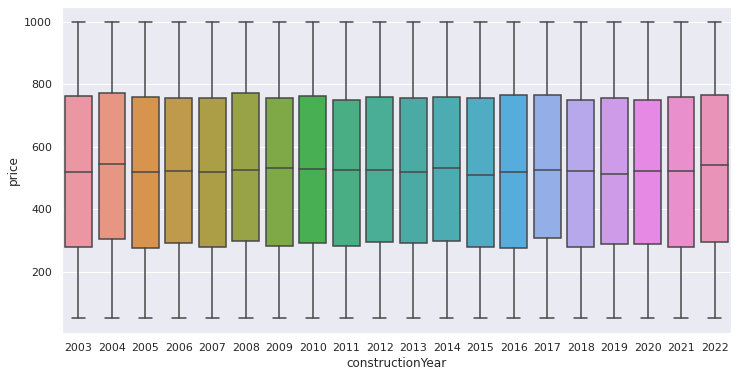

In [54]:
  sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x = 'constructionYear',       # Discrete
            y = 'price',                 # Continuous
            data = filtered_bnb
            );


**observation: older or newer properties have no influence on the price of the property.**

##**Box Plot**

Box plot is used to identify relationship between categorical and numerical feature

In [55]:
bnb['reviewRateNumber'].value_counts()

5.0    23369
4.0    23329
3.0    23265
2.0    23098
1.0     9212
Name: reviewRateNumber, dtype: int64

In [56]:
bnb.columns

Index(['HostId', 'host_identity_verified', 'NeighbourhoodGroup',
       'neighbourhood', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'roomType', 'constructionYear', 'price',
       'serviceFee', 'minimumNights', 'numberOfReviews', 'lastReview',
       'reviewsPerMonth', 'reviewRateNumber', 'calculatedHostListingsCount',
       'availability-365', 'license', 'serviceAsFracOfPrice', 'totalBill',
       'Budget', 'minimumNightsCategory'],
      dtype='object')

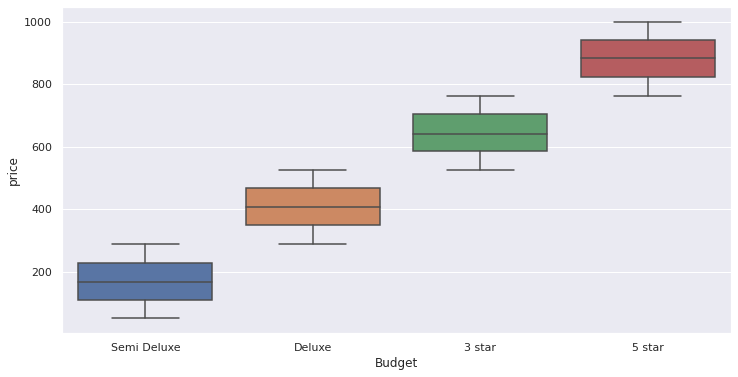

In [57]:
  sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x = 'Budget',       # Discrete
            y = 'price',                 # Continuous
            data = bnb
            );


**observation: clearly, the price of the property increases with the budget class**



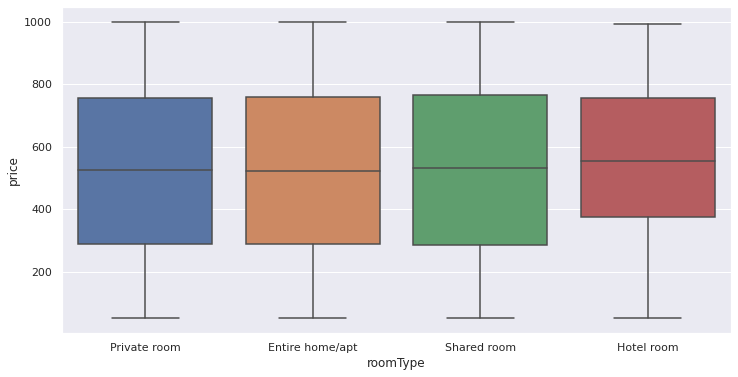

In [58]:
  sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x = 'roomType',       # Discrete
            y = 'price',                 # Continuous
            data = bnb
            );


**observation: the price range of every other type of room is similar other than for a 'Hotel room' , which has a minimum price more than others, with average price also more than for other roomtypes , but with the maximum price less than for the other room types.**

##**Joint Plot**

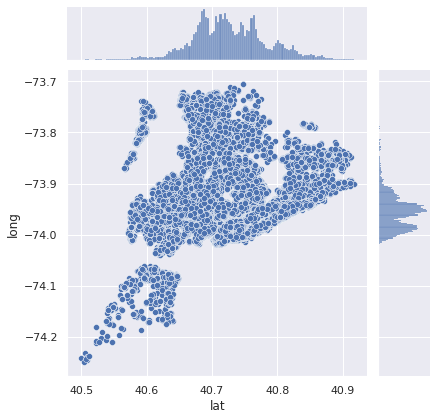

In [59]:
sns.jointplot(x=bnb.lat, y=bnb.long);

**observation:most properties are concentrated between latitude 40.3 to 40.9 and longtitude -74.0 to -73.7**

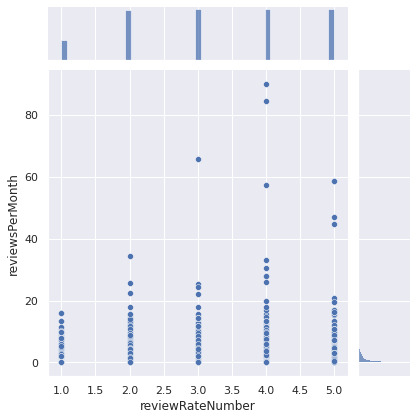

In [60]:
sns.jointplot(x=bnb.reviewRateNumber,y=bnb.reviewsPerMonth);

**observation:reviews per month are highest for properties rated 4.0 , although marginally higher than other rate number.**

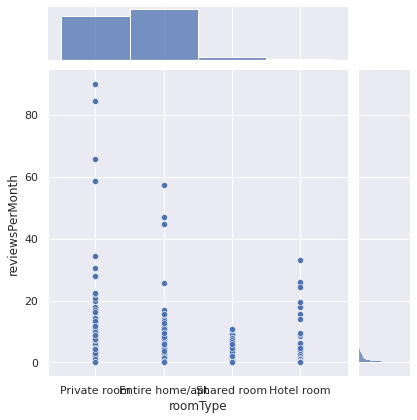

In [61]:
sns.jointplot(x=bnb.roomType,y=bnb.reviewsPerMonth);

**observation : Private roomTypes reviews higher reviews per month**

##**Bar Plot**

In [62]:
bnb.columns

Index(['HostId', 'host_identity_verified', 'NeighbourhoodGroup',
       'neighbourhood', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'roomType', 'constructionYear', 'price',
       'serviceFee', 'minimumNights', 'numberOfReviews', 'lastReview',
       'reviewsPerMonth', 'reviewRateNumber', 'calculatedHostListingsCount',
       'availability-365', 'license', 'serviceAsFracOfPrice', 'totalBill',
       'Budget', 'minimumNightsCategory'],
      dtype='object')

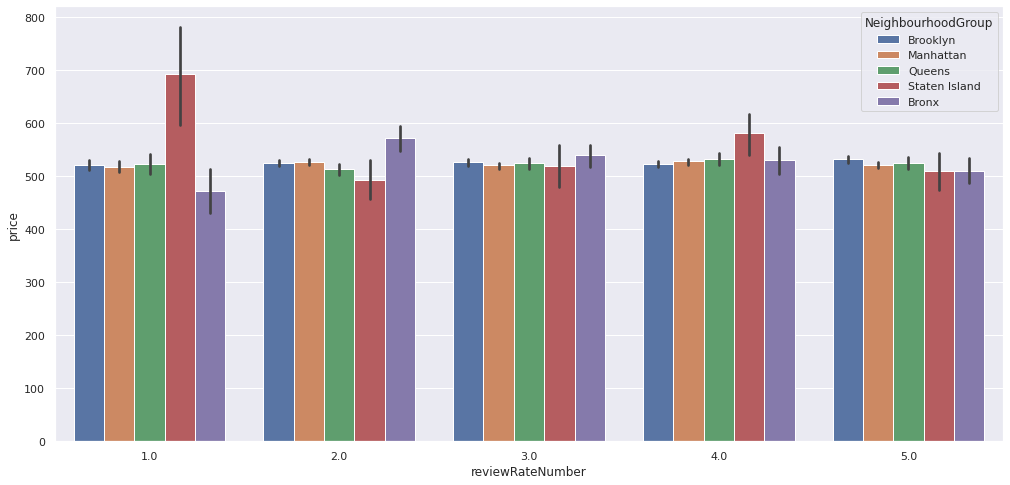

In [63]:
  sns.set(rc = {'figure.figsize':(17,8)})
sns.barplot(x = 'reviewRateNumber',
            y = 'price',
            estimator = np.mean ,     # As there are multiple occurrences of Gender, sum up 'Clicked_on_ad'
            ci = 95,                 # Estimate default confidence interval using bootstrapping
            data = bnb,               # Try np.mean also
            #capsize = 1,
            hue = 'NeighbourhoodGroup'      # Age-cat wise plots
            );

**observation : in the neighbourhood of staten island the highest priced properties have the worst rating.**

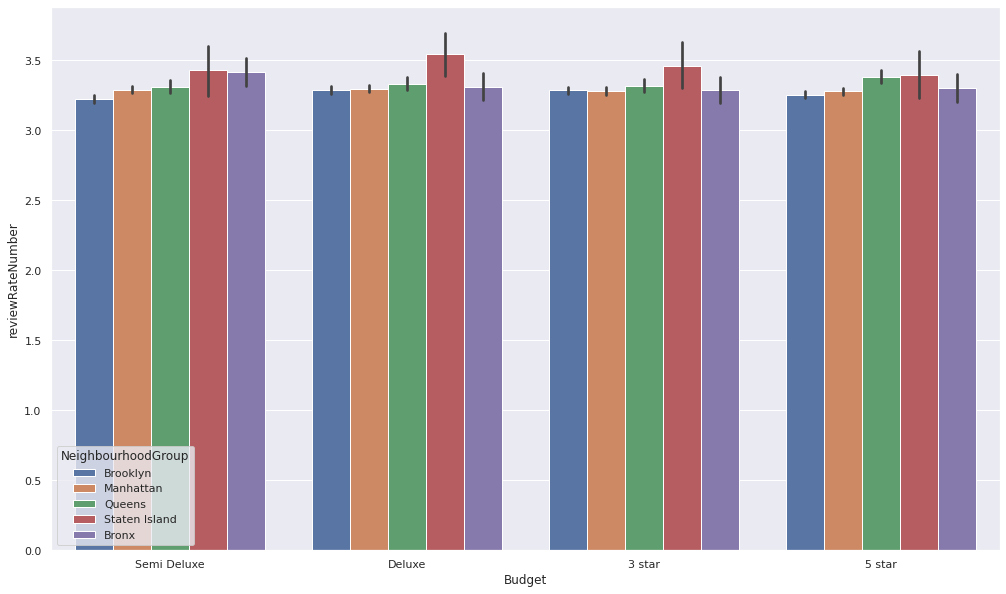

In [64]:
  sns.set(rc = {'figure.figsize':(17,10)})
sns.barplot(x = 'Budget',
            y = 'reviewRateNumber',
            estimator = np.mean ,    
            ci = 95,                
            data = bnb,               
            #capsize = 1,
            hue = 'NeighbourhoodGroup'      # Age-cat wise plots
            );

**Observations :** 

**1)Across budget classes , the properties on Staten island are rated highesst but also with high error interval.**

**2)the properties in Brooklyn are rated lowest in all categories except 3 star where properties from Manhattan are rated lowest**

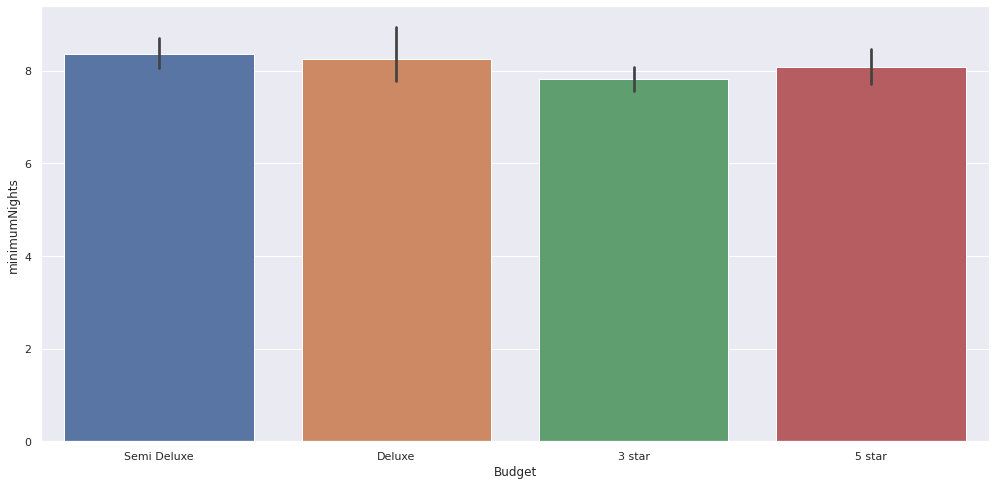

In [65]:
  sns.set(rc = {'figure.figsize':(17,8)})
sns.barplot(x = 'Budget',
            y = 'minimumNights',
            estimator = np.mean ,    
            ci = 95,                
            data = bnb,               
            #capsize = 1,
            #hue = 'NeighbourhoodGroup'      # Age-cat wise plots
            );

**observation : 3 star properties offer the least minimum nights but this cant be proclaimed as the error interal overlap with other class of budget properties**

In [66]:
bnb.columns

Index(['HostId', 'host_identity_verified', 'NeighbourhoodGroup',
       'neighbourhood', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'roomType', 'constructionYear', 'price',
       'serviceFee', 'minimumNights', 'numberOfReviews', 'lastReview',
       'reviewsPerMonth', 'reviewRateNumber', 'calculatedHostListingsCount',
       'availability-365', 'license', 'serviceAsFracOfPrice', 'totalBill',
       'Budget', 'minimumNightsCategory'],
      dtype='object')

##**Scatter Plot**

<Figure size 1224x576 with 0 Axes>

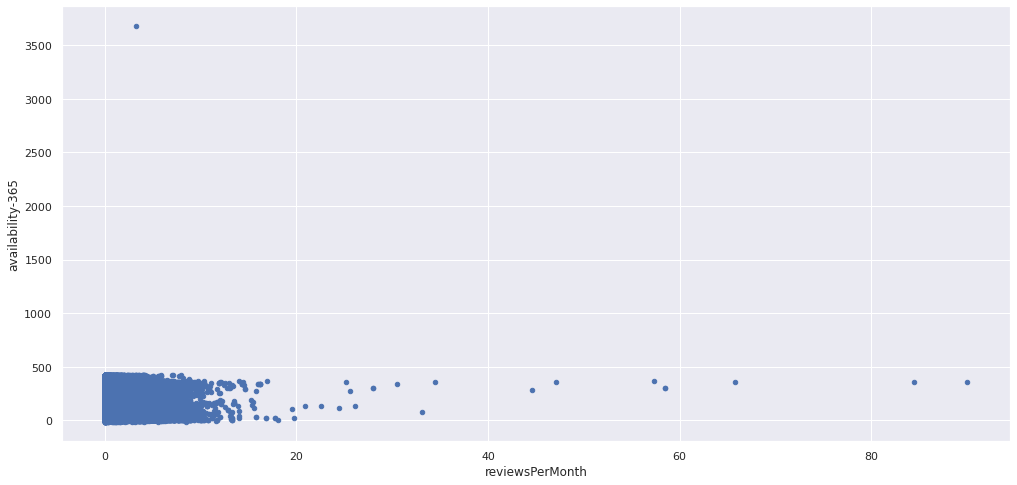

In [67]:
plt.figure()
bnb.plot.scatter(x = 'reviewsPerMonth', y = 'availability-365')
plt.show()

In [68]:
scoreatpercentile(bnb['availability-365'],99)

414.0

In [69]:
bnb['availability-365'].max()

3677.0

In [70]:
avail99perc = bnb[bnb['availability-365'] < 414]

<Figure size 1224x576 with 0 Axes>

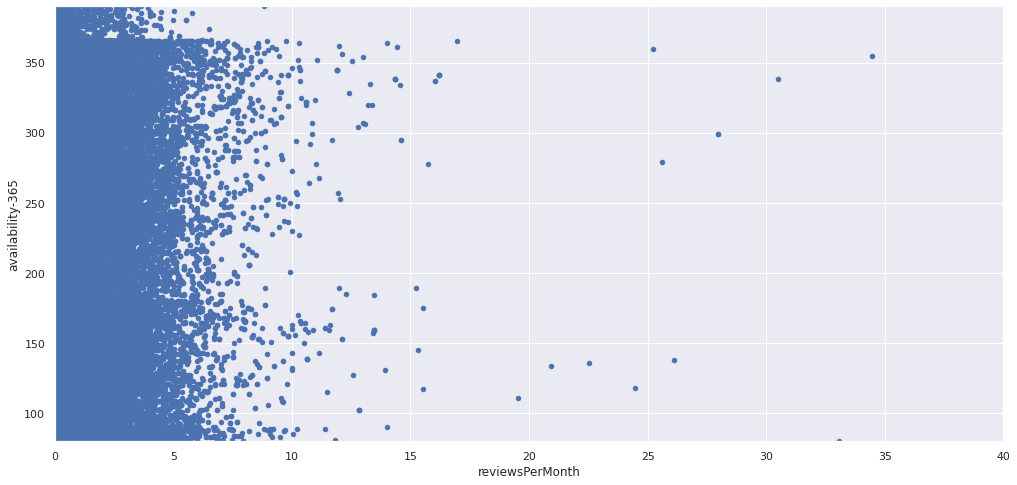

In [71]:
plt.figure()
avail99perc.plot.scatter(x = 'reviewsPerMonth', y = 'availability-365');
plt.xlim(0, 40)
plt.ylim(80, 390)
plt.show();

**Observation:marginal increase in reviews per month is seen for availabilty of around 370. However, this cannot be a conclusive remark**

##**Bar Graph**

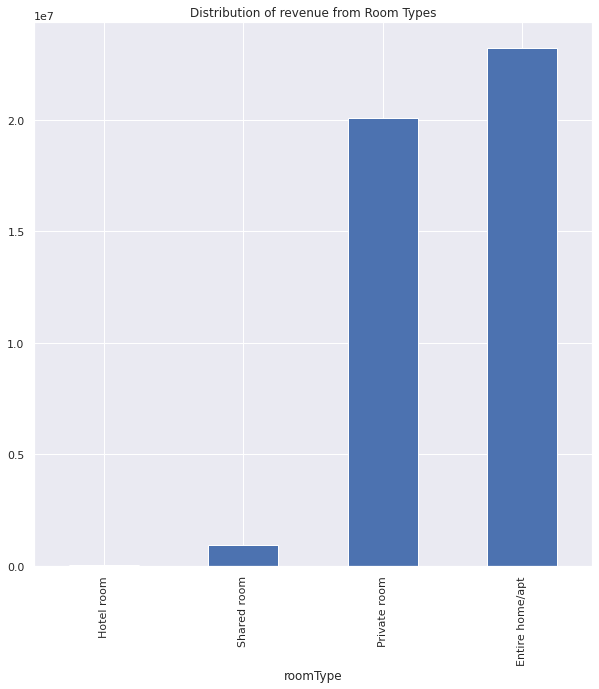

In [72]:
rev=bnb.groupby('roomType')['price'].sum().sort_values(ascending=True)
rev.plot(
           kind = 'bar',
           figsize = (10,10),
           title = "Distribution of revenue from Room Types",
           sort_columns=False
           ) ;

**Observation : Most Revenue in New York area comes from 'Entire Home/Appartment'**

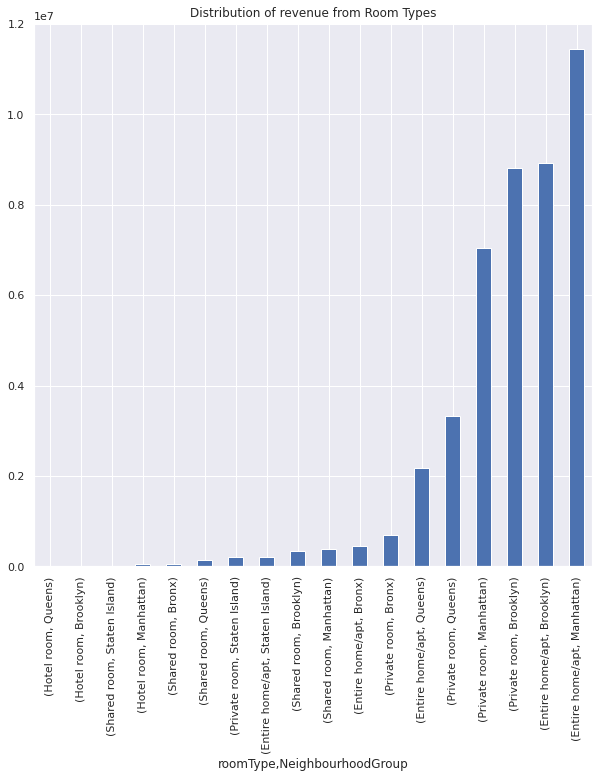

In [73]:
rev=bnb.groupby(['roomType','NeighbourhoodGroup'])['price'].sum().sort_values(ascending=True)
rev.plot(
           kind = 'bar',
           figsize = (10,10),
           title = "Distribution of revenue from Room Types",
           sort_columns=False
           ) ;

**observation : 'Entire home/apt' roomtype in Mahattan generate the most revenue among the suburbs of new york**